### Importing Directories

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from keras.utils.np_utils import to_categorical
from keras.layers import Dropout, Flatten, Conv2D, MaxPooling2D
import cv2
from sklearn.model_selection import train_test_split
import pickle
import os
import pandas as pd
import random
from keras.preprocessing.image import ImageDataGenerator

In [2]:
path="datasettraffic" #Folder with all the class folders
labelfile="labels.csv" #file with all names of classes
batch_size_val=50 #how many to process together
steps_per_epoch_val=502
epochs_val=10
imageDimensions=(32,32,3)
testRatio=0.1 #if 1000 images split will 100 for testing
validationRatio=0.2 #if 1000 images 20% of remaining 800 will be 160 for validation

### Importing of the Images

In [3]:
count=0
images=[]
classNo=[]
myList=os.listdir(path)
print("Total Classes Detected:",len(myList))
noOfClasses=len(myList) 
print("Importing Classes.....")
for x in range (0,len(myList)):
  myPicList = os.listdir(path+"/"+str(count))
  for y in myPicList:
    curImg=cv2.imread(path+"/"+str(count)+"/"+y)
    images.append(curImg)
    classNo.append(count)
  print(count, end=" ")
  count+=1
print(" ")
images=np.array(images)#.astype('uint8')
classNo=np.array(classNo)

Total Classes Detected: 43
Importing Classes.....
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42  


### Split Data

In [4]:
X_train, X_test, y_train, y_test = train_test_split(images, classNo, test_size=testRatio)
X_train, X_validation, y_train, y_validation = train_test_split(X_train,y_train,test_size=validationRatio)

### Check if number of images matches to number of labels for each data set

In [5]:
print("Data Shapes")
print("Train", end = ""); print(X_train.shape,y_train.shape)
print("Validation", end = ""); print(X_validation.shape, y_validation.shape)
print("Test", end = ""); print(X_test.shape, y_test.shape)
assert(X_train.shape[0]==y_train.shape[0])
assert(X_validation.shape[0]==y_validation.shape[0])
assert(X_test.shape[0]==y_test.shape[0])
assert(X_train.shape[1:]==(imageDimensions))
assert(X_validation.shape[1:]==(imageDimensions))
assert(X_test.shape[1:]==(imageDimensions))

Data Shapes
Train(25038, 32, 32, 3) (25038,)
Validation(6260, 32, 32, 3) (6260,)
Test(3478, 32, 32, 3) (3478,)


### Read CSV file

In [6]:
data = pd.read_csv(labelfile)
print("data shape",data.shape,type(data))

data shape (43, 2) <class 'pandas.core.frame.DataFrame'>


### Display some sample images of all the classes

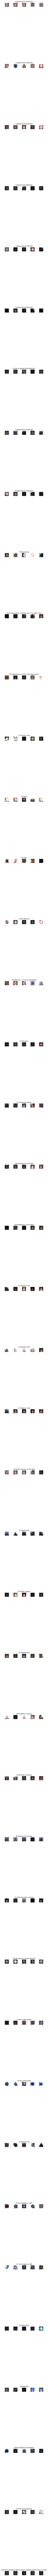

In [7]:
num_of_samples = []
cols = 5
num_classes = noOfClasses
fig, axs = plt.subplots(nrows=num_classes, ncols=cols, figsize=(5, 300))
fig.tight_layout()
for i in range(cols):
  for j, row in data.iterrows():
    x_selected = X_train[y_train == j]
    axs[j][i].imshow(x_selected[random.randint(0, len(x_selected)-1),:,:], cmap=plt.get_cmap("gray"))
    axs[j][i].axis("off")
    if i ==2:
      axs[j][i].set_title(str(j)+"-"+row["Name"])
      num_of_samples.append(len(x_selected))    

### Display a bar chart showing no. of samples for each category

[118, 1412, 1474, 927, 1263, 1188, 266, 946, 917, 947, 1318, 837, 1322, 1362, 486, 388, 266, 699, 778, 131, 221, 196, 222, 320, 179, 977, 398, 161, 330, 178, 267, 489, 149, 450, 254, 751, 246, 125, 1356, 200, 218, 151, 155]


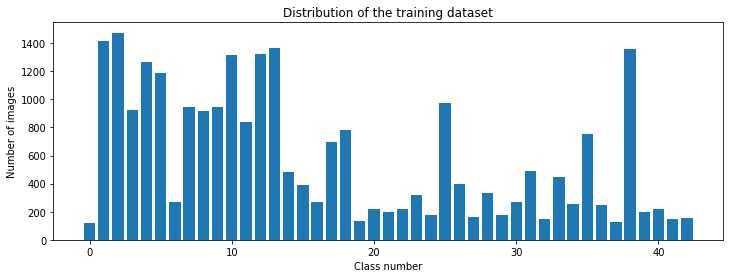

In [8]:
print(num_of_samples)
plt.figure(figsize=(12,4))
plt.bar(range(0, num_classes), num_of_samples)
plt.title("Distribution of the training dataset")
plt.xlabel("Class number")
plt.ylabel("Number of images")
plt.show()

### Preprocessing the images

In [9]:
def grayscale(img):
    img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    return img
def equalize(img):
    img = cv2.equalizeHist(img)
    return img
def preprocessing(img):
    img = grayscale(img)
    img = equalize(img)
    img = img/255
    return img

In [10]:
X_train = np.array(list(map(preprocessing,X_train)))
X_validation = np.array(list(map(preprocessing,X_validation)))
X_test = np.array(list(map(preprocessing,X_test)))
cv2.imshow("GrayScale Images", X_train[random.randint(0, len(X_train)-1)])

### Add a depth of 1

In [11]:
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1],X_train.shape[2],1)
X_validation = X_validation.reshape(X_validation.shape[0],X_validation.shape[1],X_validation.shape[2],1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1],X_test.shape[2],1)

### Augmentation of Images to make it more generic

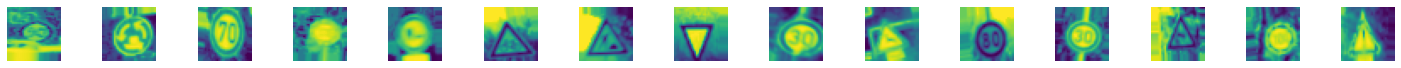

In [12]:
dataGen = ImageDataGenerator(width_shift_range = 0.1,
                            height_shift_range = 0.1,
                            zoom_range = 0.2,
                            shear_range=0.1,
                            rotation_range=10)

dataGen.fit(X_train)
batches = dataGen.flow(X_train, y_train, batch_size = 20)
X_batch, y_batch = next(batches)


fig, axs = plt.subplots(1,15,figsize=(20,5))
fig.tight_layout()

for i in range(15):
    axs[i].imshow(X_batch[i].reshape(imageDimensions[0],imageDimensions[1]))
    axs[i].axis('off')
plt.show()


y_train = to_categorical(y_train, noOfClasses)
y_validation = to_categorical(y_validation, noOfClasses)
y_test = to_categorical(y_test, noOfClasses)

### Convolution Neural Network Model

In [13]:
def myModel():
    no_Of_Filters=60
    size_of_Filter=(5,5)
    
    size_of_Filter2=(3,3)
    size_of_pool=(2,2)
    no_Of_Nodes = 500
    model = Sequential()
    model.add((Conv2D(no_Of_Filters,size_of_Filter,input_shape=(imageDimensions[0],imageDimensions[1],1),activation='relu')))
    model.add((Conv2D(no_Of_Filters,size_of_Filter, activation='relu')))
    model.add(MaxPooling2D(pool_size=size_of_pool))
    
    model.add((Conv2D(no_Of_Filters//2,size_of_Filter2,activation='relu')))
    model.add((Conv2D(no_Of_Filters//2,size_of_Filter2, activation='relu')))
    model.add(MaxPooling2D(pool_size=size_of_pool))
    model.add(Dropout(0.5))
    
    model.add(Flatten())
    model.add(Dense(no_Of_Nodes,activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(noOfClasses, activation='softmax'))
    
    model.compile(Adam(lr=0.001),loss='categorical_crossentropy', metrics=['accuracy'])
    return model

### Train

In [14]:
model = myModel()
print(model.summary())

history = model.fit(dataGen.flow(X_train,y_train,batch_size=batch_size_val), epochs=epochs_val, validation_data=(X_validation,y_validation))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 60)        1560      
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 60)        90060     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 12, 12, 60)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 10, 10, 30)        16230     
                                                                 
 conv2d_3 (Conv2D)           (None, 8, 8, 30)          8130      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 4, 4, 30)         0         
 2D)                                                    

2022-08-29 23:07:00.058777: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/himanidhawan/Desktop/venv/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


                                                                 
Total params: 378,023
Trainable params: 378,023
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
501/501 [==============================] - 134s 266ms/step - loss: 2.3839 - accuracy: 0.3351 - val_loss: 0.6300 - val_accuracy: 0.8474
Epoch 2/10
501/501 [==============================] - 137s 273ms/step - loss: 1.0654 - accuracy: 0.6748 - val_loss: 0.2333 - val_accuracy: 0.9398
Epoch 3/10
501/501 [==============================] - 132s 264ms/step - loss: 0.7490 - accuracy: 0.7709 - val_loss: 0.1549 - val_accuracy: 0.9569
Epoch 4/10
501/501 [==============================] - 135s 269ms/step - loss: 0.5735 - accuracy: 0.8225 - val_loss: 0.1210 - val_accuracy: 0.9724
Epoch 5/10
501/501 [==============================] - 126s 252ms/step - loss: 0.4739 - accuracy: 0.8522 - val_loss: 0.0940 - val_accuracy: 0.9752
Epoch 6/10
501/501 [==============================] - 125s 24

### Plot

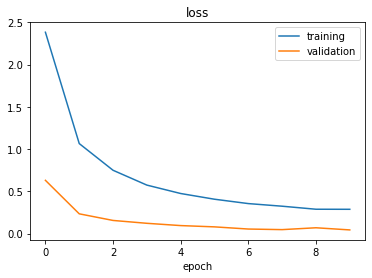

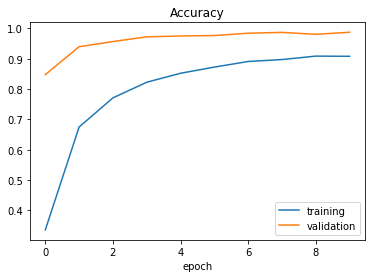

Test Score: 0.03848293796181679
Test Accuracy: 0.9882116317749023


In [15]:
plt.figure(1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training','validation'])
plt.title('loss')
plt.xlabel('epoch')
plt.show()

plt.figure(2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training','validation'])
plt.title('Accuracy')
plt.xlabel('epoch')
plt.show()

score = model.evaluate(X_test,y_test,verbose=0)
print('Test Score:', score[0])
print('Test Accuracy:', score[1])

### Save the model

In [16]:
model.save("my_model")
model.save_weights("weights.h5")

INFO:tensorflow:Assets written to: my_model/assets


INFO:tensorflow:Assets written to: my_model/assets
